# Performance Evaluation

In [1]:
import polars as pl 
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from pathlib import Path
from sklearn.decomposition import PCA
sns.set_theme(style="whitegrid")
COL_DATE='tradingDay'

In [3]:
script_dir = Path(Path.cwd()).parent
df = pl.read_parquet(script_dir / 'data' / 'synthetic_prices.parquet')
df = df.filter(pl.col('tradingDay') > datetime.date(2015,12,31))
df = df.group_by("tradingDay").first().sort("tradingDay")
df_ret = pl.read_parquet(script_dir / 'data' / 'df_ret.parquet')
df_w = pl.read_parquet(script_dir / 'data' / 'df_w.parquet')
df_w2 = pl.read_parquet(script_dir / 'data' / 'df_w2.parquet')
df_attr = pl.read_parquet(script_dir / 'data' / 'df_attr.parquet')
daily_pnl = pl.read_parquet(script_dir / 'data' / 'daily_pnl.parquet')
diag = pd.read_parquet(script_dir / 'data' / 'diag.parquet')
daily_xs = pl.read_parquet(script_dir / 'data' / 'daily_xs.parquet')
df_sig_rot = pl.read_parquet(script_dir / 'data' / 'df_sig_rot.parquet')
df_sig_cvol = pl.read_parquet(script_dir / 'data' / 'df_sig_cvol.parquet')
df_sig_vix = pl.read_parquet(script_dir / 'data' / 'df_sig_vix.parquet')
strategy = pl.read_parquet(script_dir / 'data' / 'strategy.parquet')

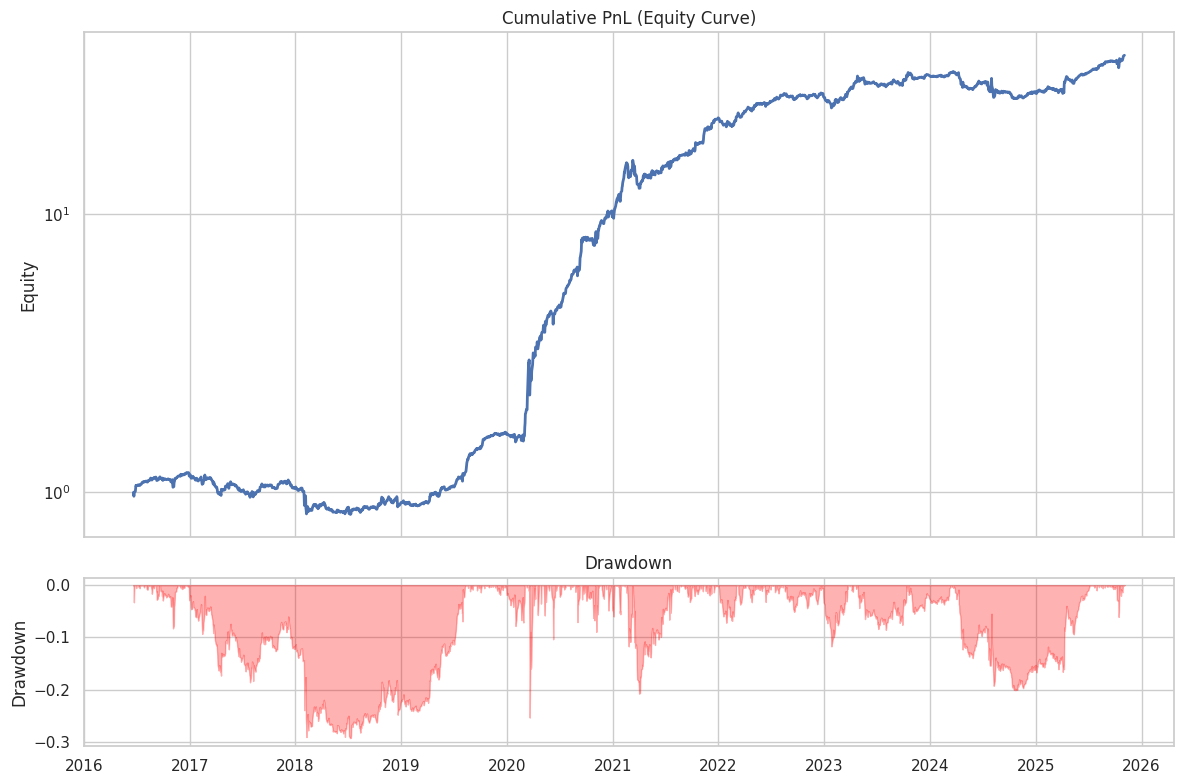

In [4]:
df = (
    strategy
    .select(["tradingDay", "sized_ret"])
    .sort("tradingDay")
    .to_pandas()
)

df["equity"] = (1.0 + df["sized_ret"]).cumprod()
df["peak"] = df["equity"].cummax()
df["drawdown"] = df["equity"] / df["peak"] - 1.0

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, 8), sharex=True,
    gridspec_kw={"height_ratios": [3, 1]}
)

ax1.plot(df["tradingDay"], df["equity"], label="Equity Curve", linewidth=2)
ax1.set_title("Cumulative PnL (Equity Curve)")
ax1.set_yscale("log")
ax1.set_ylabel("Equity")
ax1.grid(True)

ax2.fill_between(
    df["tradingDay"], df["drawdown"], 0,
    color="red", alpha=0.3
)
ax2.set_title("Drawdown")
ax2.set_ylabel("Drawdown")
ax2.grid(True)

plt.tight_layout()
plt.show()


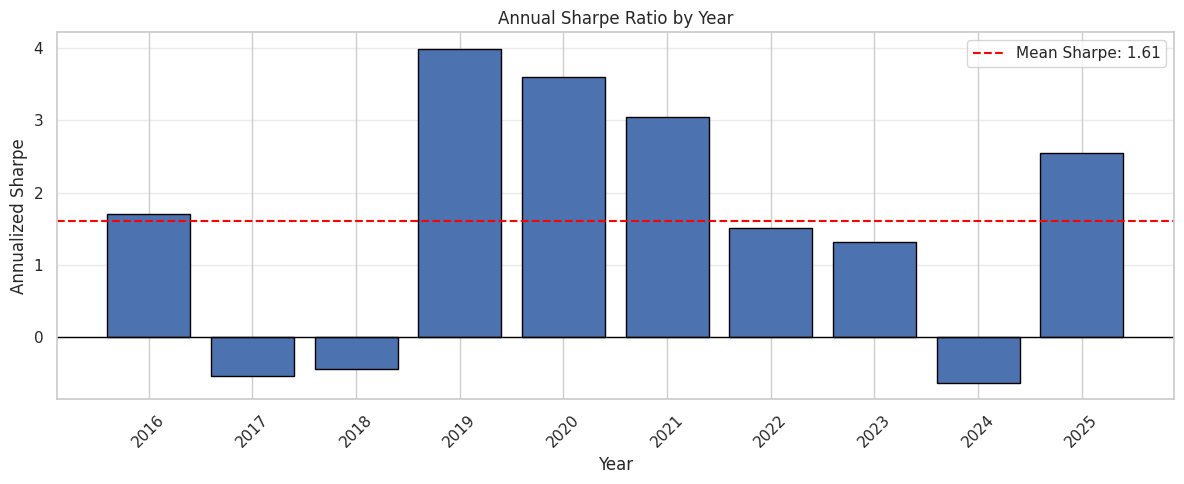

In [5]:
df["year"] = pd.to_datetime(df["tradingDay"]).dt.year

annual_stats = (
    df.groupby("year")["sized_ret"]
    .agg(["mean", "std", "count"])
)

annual_stats["sharpe"] = (
    annual_stats["mean"] / annual_stats["std"] * np.sqrt(252)
)

# --- Plot ---
plt.figure(figsize=(12, 5))

plt.bar(
    annual_stats.index.astype(str),
    annual_stats["sharpe"],
    edgecolor="black"
)

plt.axhline(0, linewidth=1.0, color="black")
plt.axhline(
    annual_stats["sharpe"].mean(),
    linestyle="--",
    color="red",
    label=f"Mean Sharpe: {annual_stats['sharpe'].mean():.2f}"
)

plt.title("Annual Sharpe Ratio by Year")
plt.xlabel("Year")
plt.ylabel("Annualized Sharpe")
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis="y", alpha=0.4)

plt.tight_layout()
plt.show()


In [6]:
rets = df["sized_ret"]

stats = {
    "Mean Annualized Return": rets.mean() * 252,
    "Annualized Volatility": rets.std() * np.sqrt(252),
    "Sharpe Ratio": (rets.mean() / rets.std()) * np.sqrt(252),
    "Win Rate": (rets > 0).mean(),
    "Average Win": rets[rets > 0].mean(),
    "Average Loss": rets[rets < 0].mean(),
    "% Win": (rets > 0).mean() * 100,
    "Skewness": rets.skew(),
    "Kurtosis": rets.kurtosis(),
    "Max Drawdown": df["drawdown"].min(),
}

stats_df = pd.DataFrame(stats, index=["Strategy"]).T
stats_df.loc["Downside Vol (ann)"] = (
    rets[rets < 0].std() * np.sqrt(252) 
)

stats_df.loc["Sortino Ratio"] = (
    rets.mean() / rets[rets < 0].std() * np.sqrt(252)
)

stats_df


,Strategy
Mean Annualized Return,0.414620
Annualized Volatility,0.247684
Sharpe Ratio,1.673989
Win Rate,0.554714
Average Win,0.009283
Average Loss,-0.007870
% Win,55.471380
Skewness,2.226443
Kurtosis,52.477400
Max Drawdown,-0.292503


## Scaled vs Unscaled Strategy Comparison

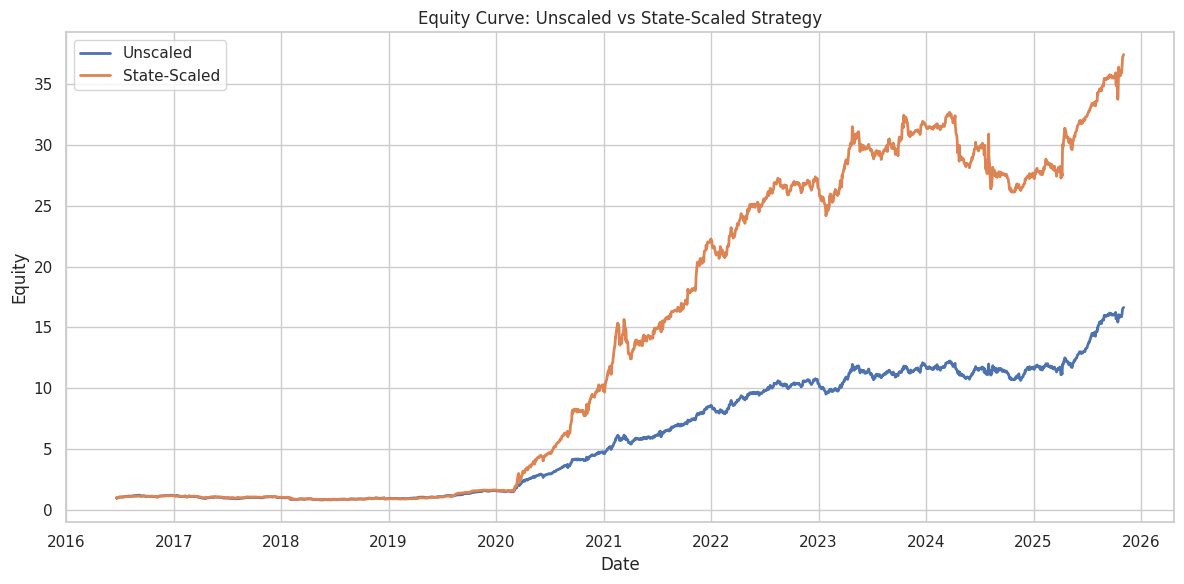

In [9]:
df_cmp = (
    strategy
    .select(["tradingDay", "forward_ret"])
    .join(
        strategy.select(["tradingDay", "sized_ret"]),
        on="tradingDay",
        how="inner"
    )
    .sort("tradingDay")
    .to_pandas()
)

df_cmp["year"] = pd.to_datetime(df_cmp["tradingDay"]).dt.year

df_cmp["equity_unscaled"] = (1.0 + df_cmp["forward_ret"]).cumprod()
df_cmp["equity_scaled"]   = (1.0 + df_cmp["sized_ret"]).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(df_cmp["tradingDay"], df_cmp["equity_unscaled"], label="Unscaled", linewidth=2)
plt.plot(df_cmp["tradingDay"], df_cmp["equity_scaled"], label="State-Scaled", linewidth=2)
plt.title("Equity Curve: Unscaled vs State-Scaled Strategy")
plt.ylabel("Equity")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Log scale

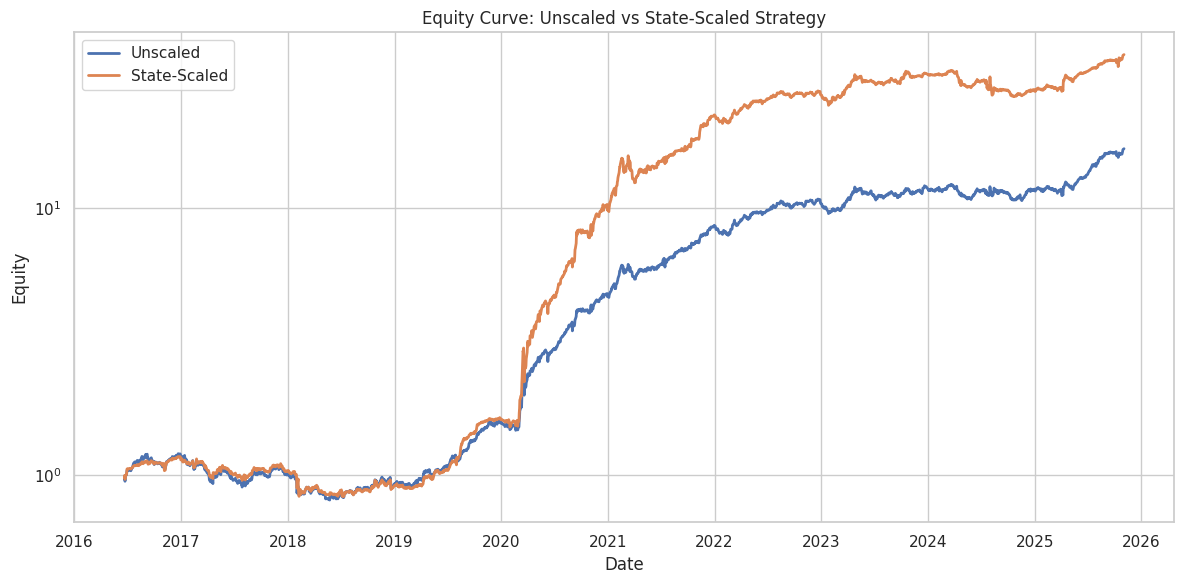

In [10]:
df_cmp = (
    strategy
    .select(["tradingDay", "forward_ret"])
    .join(
        strategy.select(["tradingDay", "sized_ret"]),
        on="tradingDay",
        how="inner"
    )
    .sort("tradingDay")
    .to_pandas()
)

df_cmp["year"] = pd.to_datetime(df_cmp["tradingDay"]).dt.year

df_cmp["equity_unscaled"] = (1.0 + df_cmp["forward_ret"]).cumprod()
df_cmp["equity_scaled"]   = (1.0 + df_cmp["sized_ret"]).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(df_cmp["tradingDay"], df_cmp["equity_unscaled"], label="Unscaled", linewidth=2)
plt.plot(df_cmp["tradingDay"], df_cmp["equity_scaled"], label="State-Scaled", linewidth=2)
plt.yscale("log")
plt.title("Equity Curve: Unscaled vs State-Scaled Strategy")
plt.ylabel("Equity")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

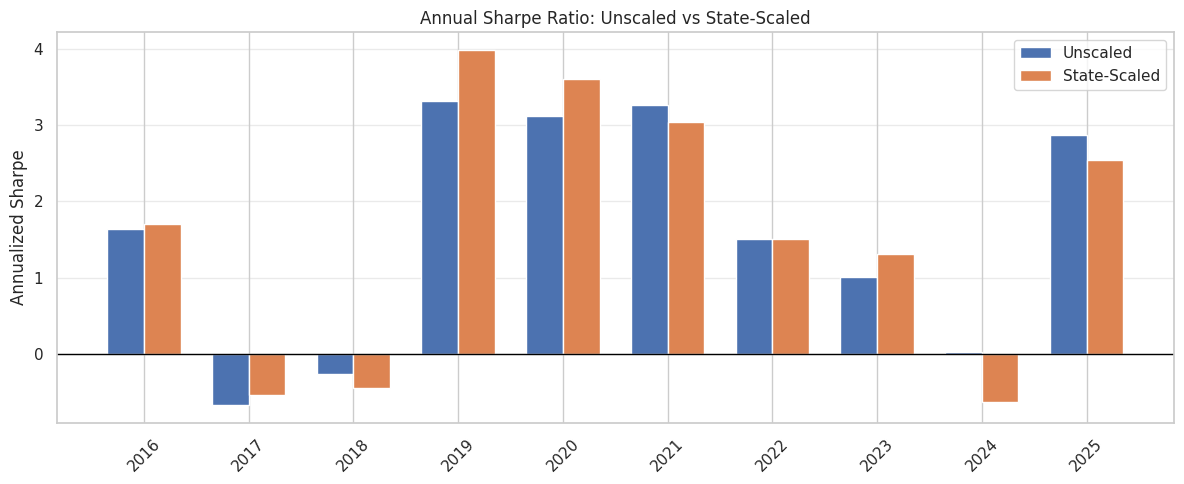

,Unscaled,State-Scaled
year,,
2016,1.638468,1.702174
2017,-0.670612,-0.541408
2018,-0.266493,-0.442473
2019,3.321180,3.985263
2020,3.118502,3.600026
2021,3.265318,3.048456
2022,1.508590,1.511962
2023,1.003565,1.308655
2024,0.020085,-0.630318


In [11]:
def annual_sharpe(series):
    return series.mean() / series.std() * np.sqrt(252)

annual = (
    df_cmp
    .groupby("year")
    .agg({
        "forward_ret": annual_sharpe,
        "sized_ret": annual_sharpe
    })
    .rename(columns={
        "forward_ret": "Unscaled",
        "sized_ret": "State-Scaled"
    })
)

plt.figure(figsize=(12, 5))
x = np.arange(len(annual.index))
w = 0.35

plt.bar(x - w/2, annual["Unscaled"], width=w, label="Unscaled")
plt.bar(x + w/2, annual["State-Scaled"], width=w, label="State-Scaled")

plt.axhline(0, color="black", linewidth=1)
plt.xticks(x, annual.index.astype(str), rotation=45)
plt.ylabel("Annualized Sharpe")
plt.title("Annual Sharpe Ratio: Unscaled vs State-Scaled")
plt.legend()
plt.grid(axis="y", alpha=0.4)
plt.tight_layout()
plt.show()

annual


In [12]:
df_attr = (
    strategy
    .select([
        "tradingDay",
        "sized_ret",
        "pca_rotation_state",
        "pc1_var_state",
        "std_r_state",
        "VIX_state",
    ])
    .to_pandas()
)

def pnl_by_state(df, state_col):
    out = (
        df.groupby(state_col)["sized_ret"]
        .agg(
            n_days="count",
            mean_daily="mean",
            vol_daily="std",
            total_pnl="sum",
        )
    )
    out["sharpe"] = out["mean_daily"] / out["vol_daily"] * np.sqrt(252)
    out["pct_total_pnl"] = out["total_pnl"] / out["total_pnl"].sum()
    return out.sort_values("pct_total_pnl", ascending=False)


In [13]:
pnl_by_state(df_attr, "pca_rotation_state")

/tmp/ipykernel_1271595/1822356887.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(state_col)["sized_ret"]


,n_days,mean_daily,vol_daily,total_pnl,sharpe,pct_total_pnl
pca_rotation_state,,,,,,
UNSTABLE,796,0.002303,0.022080,1.833061,1.655654,0.468900
TRANSITION,780,0.001938,0.013287,1.511551,2.315274,0.386657
STABLE,800,0.000706,0.008064,0.564666,1.389514,0.144443


In [14]:
pnl_by_state(df_attr, "pc1_var_state")

/tmp/ipykernel_1271595/1822356887.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(state_col)["sized_ret"]


,n_days,mean_daily,vol_daily,total_pnl,sharpe,pct_total_pnl
pc1_var_state,,,,,,
MULTI_DIM,1201,0.002111,0.017380,2.534715,1.927714,0.648384
ONE_DIM,1175,0.001170,0.013538,1.374563,1.371698,0.351616


In [15]:
pnl_by_state(df_attr, "std_r_state")

/tmp/ipykernel_1271595/1822356887.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(state_col)["sized_ret"]


,n_days,mean_daily,vol_daily,total_pnl,sharpe,pct_total_pnl
std_r_state,,,,,,
HIGH_DISPERSION,415,0.005215,0.029064,2.164379,2.848635,0.553652
HIGHMID_DISPERSION,475,0.001320,0.013089,0.627035,1.600949,0.160397
MID_DISPERSION,496,0.001006,0.010690,0.499147,1.494356,0.127683
LOWMID_DISPERSION,495,0.000940,0.011126,0.465223,1.340987,0.119005
LOW_DISPERSION,495,0.000310,0.006804,0.153493,0.723459,0.039264


In [16]:
pnl_by_state(df_attr, "VIX_state")

/tmp/ipykernel_1271595/1822356887.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(state_col)["sized_ret"]


,n_days,mean_daily,vol_daily,total_pnl,sharpe,pct_total_pnl
VIX_state,,,,,,
HIGH,1195,0.002975,0.020504,3.555013,2.303200,0.909378
LOW,1181,0.000300,0.007808,0.354265,0.609855,0.090622
